#### Compute bootstrap CIs for fractal dimension power law fits (OHT)
- Zachary Neronha and Dhananjay Bhaskar
- 29 November 2018

In [1]:
library(R.matlab)
library(repr)
library(boot)
library(MASS)
library(reticulate)

R.matlab v3.6.2 (2018-09-26) successfully loaded. See ?R.matlab for help.

Attaching package: ‘R.matlab’

The following objects are masked from ‘package:base’:

    getOption, isOpen



#### MATLAB Computation

In [2]:
mat = readMat("OHT_data.mat")
str(mat$Rmat)
xdata = mat$Rmat[,1]
ydata = mat$Rmat[,2]

 num [1:4516, 1:2] 4 5 5 12 12 11 7 12 5 9 ...


In [3]:
plaw = function(x,a,b){a*x^(b)}

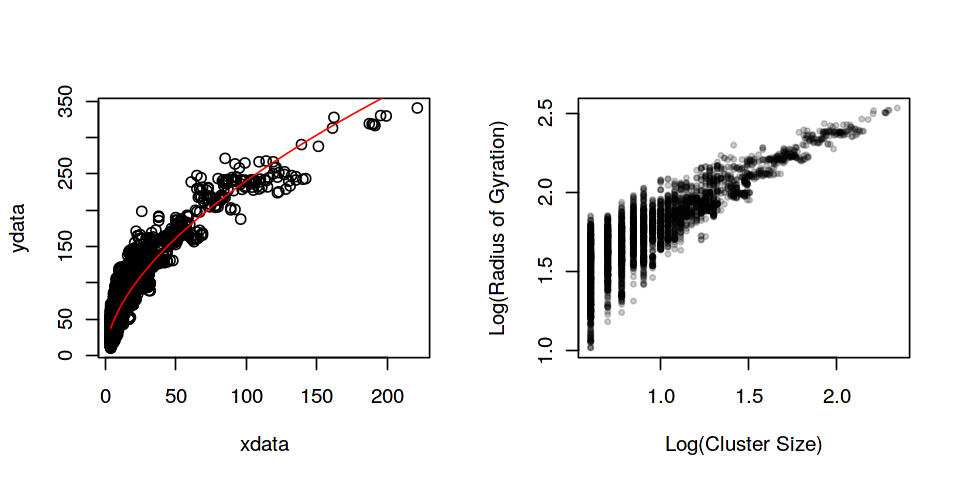

In [4]:
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow=c(1,2))

plot(xdata, ydata)
curve(plaw(x, 16.98, 0.5756), add=TRUE, col="red")

plot(log10(xdata), log10(ydata), type="p", xlab="Log(Cluster Size)", ylab="Log(Radius of Gyration)", 
    cex=0.5, pch=21, col=rgb(0,0,0,alpha=0.2), bg=rgb(0,0,0,alpha=0.2))

#### Model fitting results obtained from MATLAB
     General model Power1:
     f(x) = a*x^b
     Coefficients (with 95% confidence bounds):
       a =       16.98  (16.68, 17.28)
       b =      0.5756  (0.5705, 0.5808)

#### R Non-linear Least Squares Fit

In [5]:
fit = nls(ydata~plaw(xdata,a,b),start=list(a=16,b=0.5))
print(fit)

Nonlinear regression model
  model: ydata ~ plaw(xdata, a, b)
   data: parent.frame()
      a       b 
16.9799  0.5756 
 residual sum-of-squares: 1065402

Number of iterations to convergence: 4 
Achieved convergence tolerance: 5.314e-06


In [6]:
print(names(fit))
sum(residuals(fit)^2)
a = coef(fit)[1]
b = coef(fit)[2]
print(c(a,b))

[1] "m"           "convInfo"    "data"        "call"        "dataClasses"
[6] "control"    


[1] 1065402

         a          b 
16.9799185  0.5756188 


#### Compute R Bootstrap Confidence Intervals for Regression Parameters

In [7]:
Cdata = cbind(xdata,ydata)
print(dim(Cdata))

[1] 4516    2


In [8]:
bs = function(data, indices) {
    ds = data[indices,]
    xs = ds[,1]
    ys = ds[,2]
    fit = nls(ys~plaw(xs,a,b),start=list(a=16,b=0.5))
    SSR = sum(residuals(fit)^2)
    a = coef(fit)[1]
    b = coef(fit)[2]
    return(c(a,b))
} 

In [21]:
results = boot(data=Cdata, statistic=bs, R=10000)

In [22]:
print(results)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Cdata, statistic = bs, R = 10000)


Bootstrap Statistics :
      original        bias    std. error
t1* 16.9799185 -0.0095534530 0.178049268
t2*  0.5756188  0.0002227097 0.003441915


In [23]:
boot.ci(results, type="bca") 

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 10000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   (16.64, 17.34 )  
Calculations and Intervals on Original Scale

In [25]:
boot.ci(results, type="bca",index=2) 

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 10000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca", index = 2)

Intervals : 
Level       BCa          
95%   ( 0.5689,  0.5822 )  
Calculations and Intervals on Original Scale

In [26]:
avec = results$t[,1]
bvec = results$t[,2]

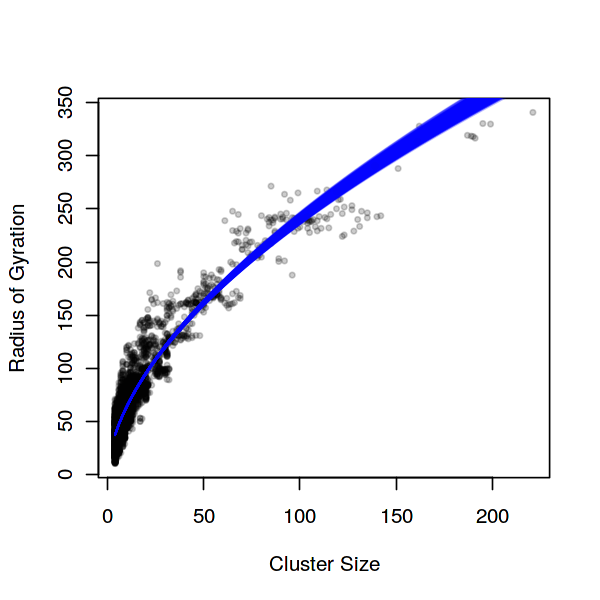

In [27]:
options(repr.plot.width = 5, repr.plot.height = 5)
plot(xdata, ydata, type="p", xlab="Cluster Size", ylab="Radius of Gyration", 
     cex=0.5, pch=21, col=rgb(0,0,0,alpha=0.2), bg=rgb(0,0,0,alpha=0.2))
for (i in seq(1, length(avec))){
    curve(plaw(x, avec[i], bvec[i]), add = TRUE, col = rgb(0,0,1,alpha=0.1))
}

In [91]:
writeMat("OHT_boot.mat", a = avec, b = bvec)

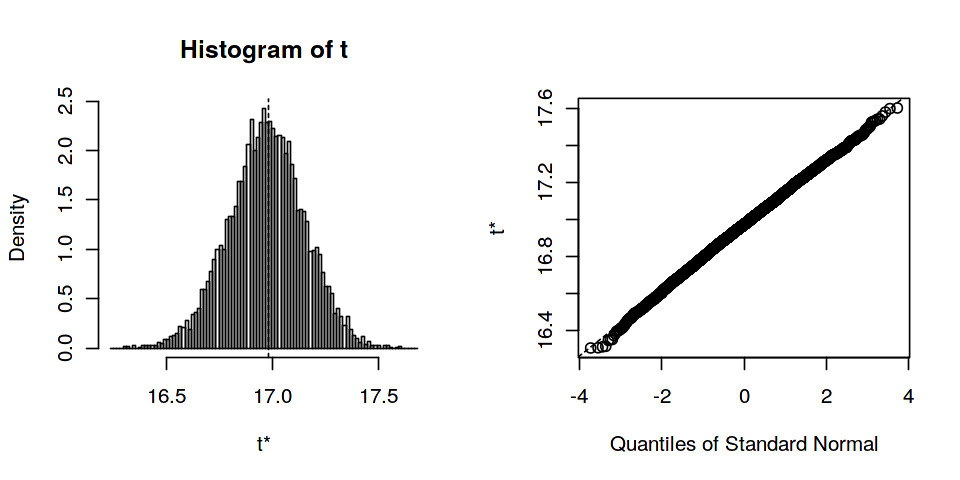

In [28]:
options(repr.plot.width = 8, repr.plot.height = 4)
plot(results,index=1)

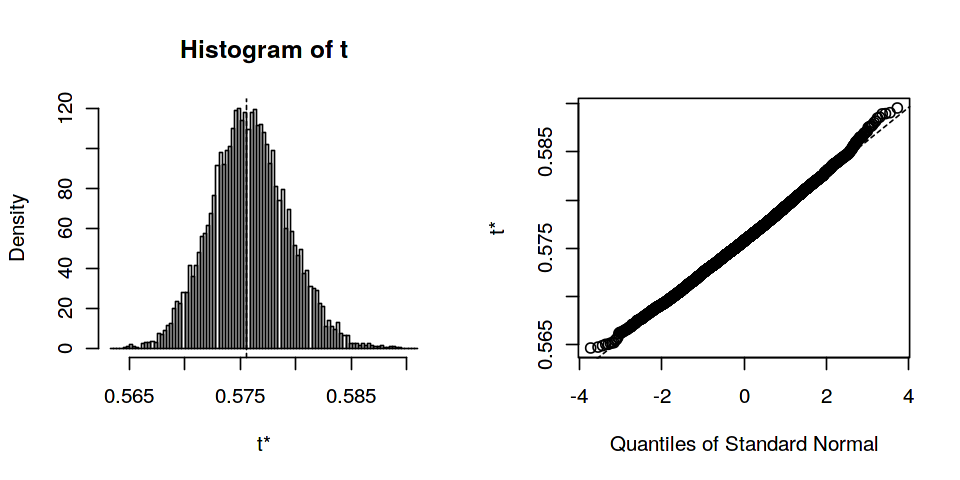

In [29]:
options(repr.plot.width = 8, repr.plot.height = 4)
plot(results,index=2)

#### Compute KDE

In [23]:
kde_data = kde2d(xdata, ydata, h=15, n=1000, lims = c(range(xdata), range(ydata)))

[1] "x" "y" "z"

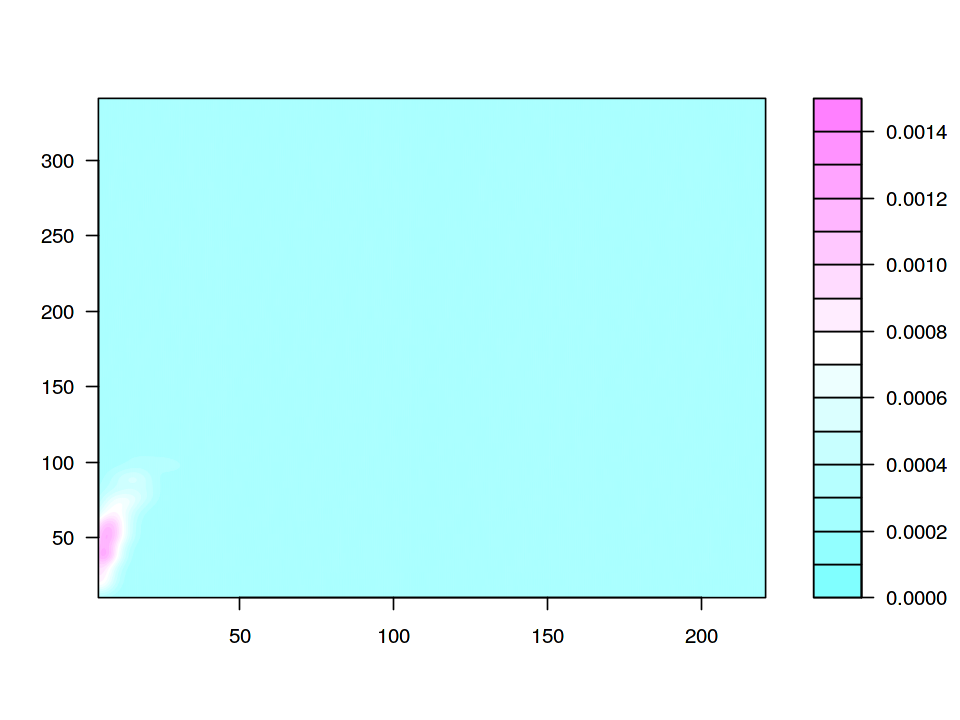

In [24]:
names(kde_data)
density = log10(kde_data$z)
options(repr.plot.width = 8, repr.plot.height = 6)
filled.contour(x=kde_data$x,y=kde_data$y,z=kde_data$z)

In [25]:
mean_RG = c()
var_RG = c()

for (k in seq(1,1000)){
    
    mean_val = sum(kde_data$z[k,]*kde_data$y)/sum(kde_data$z[k,])
    
    var_val = sum(kde_data$z[k,]*(kde_data$y)^2)/sum(kde_data$z[k,]) - mean_val^2
    
    mean_RG = c(mean_RG, mean_val)
    
    var_RG = c(var_RG, var_val)
   
}

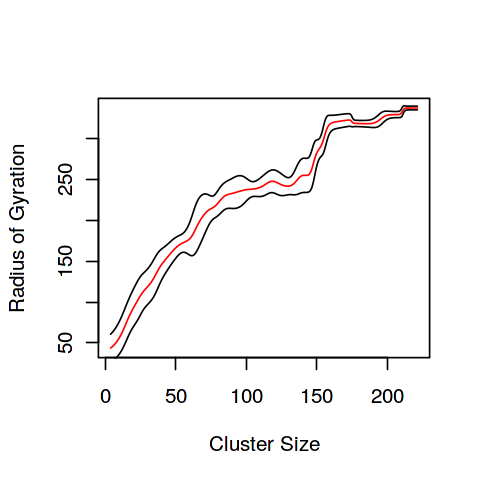

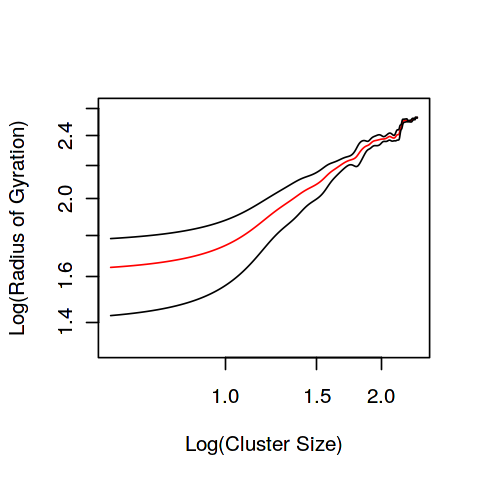

In [26]:
options(repr.plot.width = 4, repr.plot.height = 4)

plot(kde_data$x,mean_RG, xlab = "Cluster Size", ylab="Radius of Gyration", type="l", col="red")
lines(kde_data$x,mean_RG + sqrt(var_RG))
lines(kde_data$x, mean_RG - sqrt(var_RG))


plot(log10(kde_data$x), log10(mean_RG), xlab = "Log(Cluster Size)", 
     ylim=c(1.3,2.6), ylab="Log(Radius of Gyration)", log = "xy", type="l", col="red")
lines(log10(kde_data$x),log10(mean_RG + sqrt(var_RG)))
lines(log10(kde_data$x), log10(mean_RG - sqrt(var_RG)))

#### Image Analysis

In [72]:
np = import("numpy")
mat = np$load("Img_Analysis_Fractal_Dim_OHT.npy")

In [73]:
str(mat)

 num [1:4306, 1:2] 2335 2522 2495 1368 2539 ...


In [74]:
xdata = mat[,1]
ydata = mat[,2]

In [75]:
plaw = function(x,a,b){a*x^(b)}

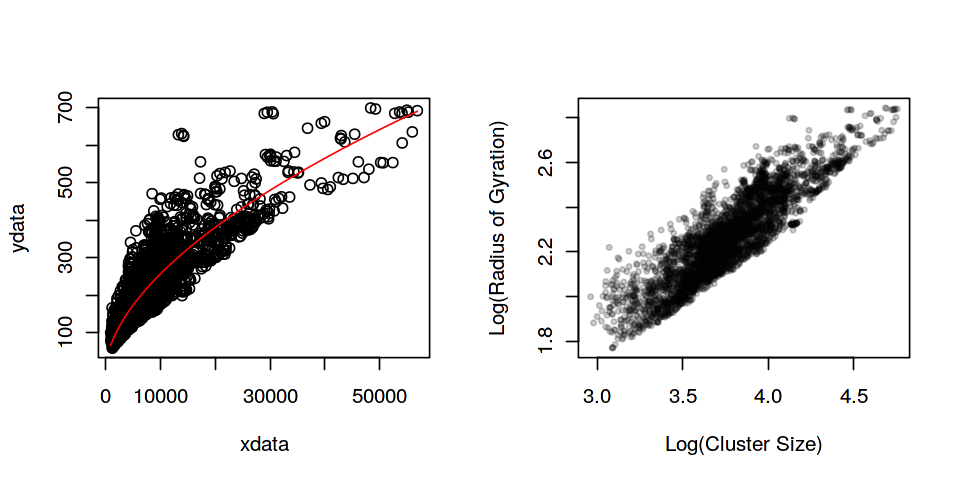

In [80]:
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow=c(1,2))

plot(xdata, ydata)
curve(plaw(x, 1.3523, 0.5695), add=TRUE, col="red")

plot(log10(xdata), log10(ydata), type="p", xlab="Log(Cluster Size)", ylab="Log(Radius of Gyration)", 
    cex=0.5, pch=21, col=rgb(0,0,0,alpha=0.2), bg=rgb(0,0,0,alpha=0.2))

In [81]:
fit = nls(ydata~plaw(xdata,a,b),start=list(a=1.35,b=0.55))
print(fit)

Nonlinear regression model
  model: ydata ~ plaw(xdata, a, b)
   data: parent.frame()
     a      b 
1.3523 0.5695 
 residual sum-of-squares: 8905500

Number of iterations to convergence: 3 
Achieved convergence tolerance: 1.405e-06


In [82]:
print(names(fit))
sum(residuals(fit)^2)
a = coef(fit)[1]
b = coef(fit)[2]
print(c(a,b))

[1] "m"           "convInfo"    "data"        "call"        "dataClasses"
[6] "control"    


[1] 8905500

        a         b 
1.3522538 0.5694574 


In [83]:
Cdata = cbind(xdata,ydata)
print(dim(Cdata))

[1] 4306    2


In [84]:
bs = function(data, indices) {
    ds = data[indices,]
    xs = ds[,1]
    ys = ds[,2]
    fit = nls(ys~plaw(xs,a,b),start=list(a=1.35,b=0.55))
    SSR = sum(residuals(fit)^2)
    a = coef(fit)[1]
    b = coef(fit)[2]
    return(c(a,b))
} 

In [85]:
results = boot(data=Cdata, statistic=bs, R=1000)

In [86]:
print(results)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Cdata, statistic = bs, R = 1000)


Bootstrap Statistics :
     original        bias    std. error
t1* 1.3522538  0.0036769661 0.056561748
t2* 0.5694574 -0.0001835926 0.004681701


In [87]:
avec = results$t[,1]
bvec = results$t[,2]

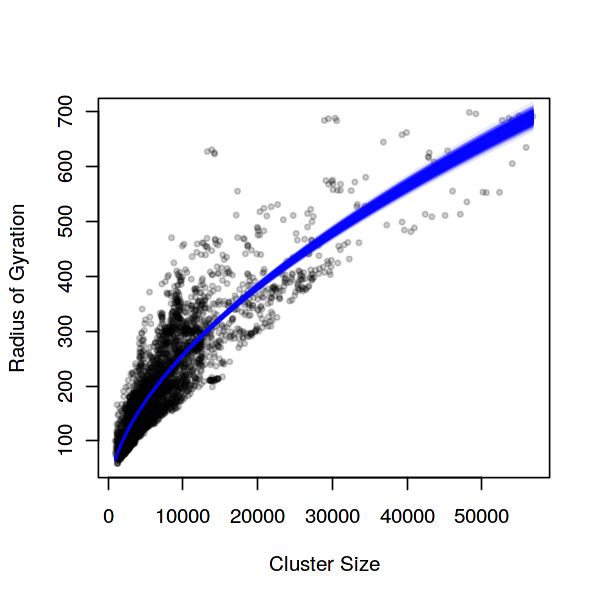

In [88]:
options(repr.plot.width = 5, repr.plot.height = 5)
plot(xdata, ydata, type="p", xlab="Cluster Size", ylab="Radius of Gyration", 
     cex=0.5, pch=21, col=rgb(0,0,0,alpha=0.2), bg=rgb(0,0,0,alpha=0.2))
for (i in seq(1, length(avec))){
    curve(plaw(x, avec[i], bvec[i]), add = TRUE, col = rgb(0,0,1,alpha=0.1))
}

In [89]:
writeMat("Img_Analysis_boot.mat", a = avec, b = bvec)

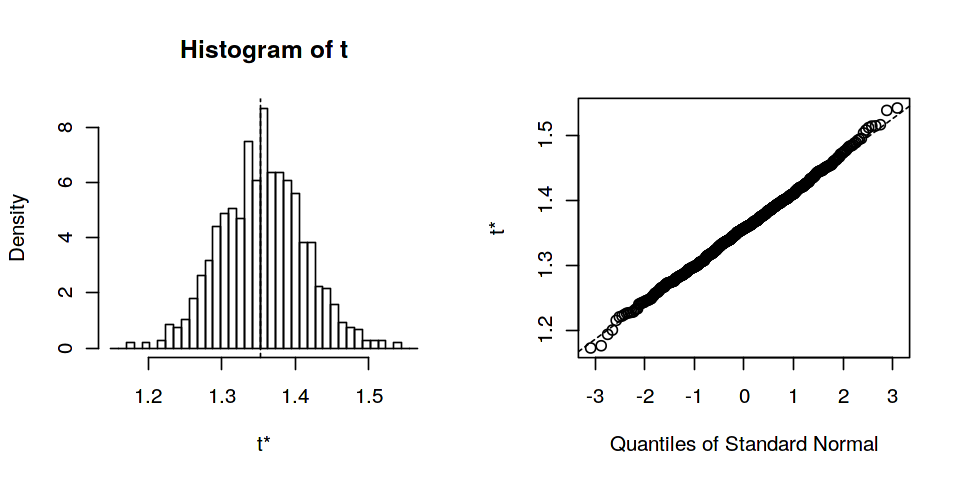

In [90]:
options(repr.plot.width = 8, repr.plot.height = 4)
plot(results,index=1)